# Workflow: droog profiel toevoegen

## Context
Momenteel is er een database beschikbaar in WIT voor de bodemhoogtes van het natte profiel, maar het droge profiel is ook relevant voor verschillende doeleinden (bijv. het modelleren van hoog water). In deze workflow wordt de bodemhoogte voor het droge profiel uitgelezen uit AHN data en toegevoegd aan het natte profiel.

Hierbij is de volgende codering voor de puntmetingen gehanteerd:

A23    : droog profiel, begin  <br>
A24    : droog profiel, linker insteek punt (o.b.v. AHN) <br>
A31    : droog profiel, links (o.b.v. AHN)  <br>
A22L   : nat profiel, water grens linker kant (o.b.v. WIT) <br>
A99  : nat profiel (o.b.v. WIT) <br>
A22R : nat profiel, water grens rechter kant (o.b.v. WIT) <br>
A32    : droog profiel, rechts (o.b.v. AHN)  <br>
A28  : droog profiel, rechter insteek punt (o.b.v. AHN)  <br>
A29    : droog profiel, einde  <br>


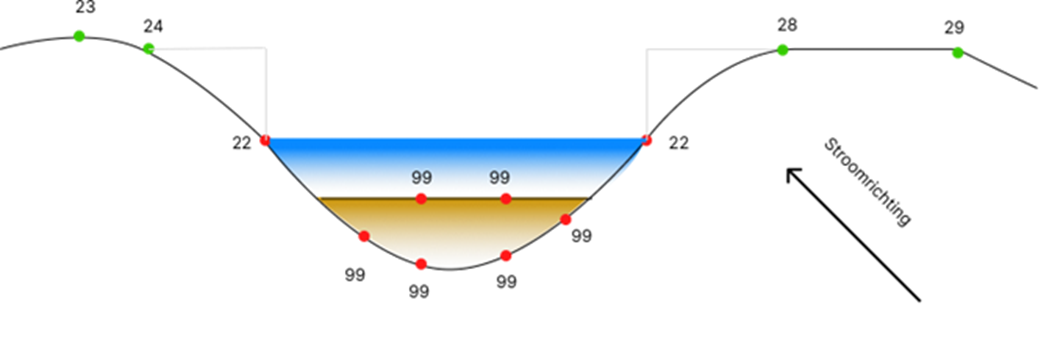

#### Belangrijk:
Het is belangrijk dat een vast format gehanteerd wordt in de input data. Anders crasht de code namelijk.

## Profielen inlezen

Exporteer allereerst WIT profiel data als shapefile met point-features. Volg hiervoor de volgende stappen:
- Selecteer alle baggerprofielen met de selecteer-tool (links bovenin)
- Zorg dat de gearchiveerde baggerprofielen uit staan (kan in tabel rechts)
- Klik op 'Export' (rechts boven) en dan 
    - ‘Exporteer generieke geometrie’:
        - Type export: Profielpunt
        - Feature format: shapefile
    - 'Profielen naar ASCII' (daar staan namelijk de Hydro Object codes)

## Profielen bewerken

In de volgende stappen wordt het droge gedeelte toegevoegd aan de shapefile. Het gaat hierbij om de bodemhoogte bij de insteek (A24 en A28).

#### Modules inlezen

In [1]:
import os
import functies_droog_profiel
import functies_droog_profiel_filters
import functies_droog_profiel_extra
from datetime import datetime
tstart = datetime.now()

#### Paden definieren
De bestandnamen en locaties kunnen aangepast worden. Maar de variabel-namen niet.

In [2]:
class paths:
    root   = os.getcwd()
    output = os.path.join(root,'Output')
    
    # Input
    shp_insteek         = os.path.join(root,'GIS_input','BR-VS_Insteekvlak.shp')
    shp_water           = os.path.join(root,'GIS_input','BR_VS_Watervlak.shp')
    shp_HO              = os.path.join(root,'GIS_input','BR_VS_HydroObject.shp')
    tif_AHN             = os.path.join(root,'GIS_input','AHN4 grondfilter.tif')
    shp_WIT             = os.path.join(root,'GIS_input','WIT_export_18082023_orig.shp')    
    df_WIT              = os.path.join(root,'GIS_input','WIT_ascii_file_06032024.txt')
    
    # Tijdelijke output bestanden (worden aan het einde van de workflow weer verwijderd)
    shp_WIT_edited    = os.path.join(output,'WIT_export_18082023_all.shp')    
    shp_profielen_nat = os.path.join(output,'WIT_export_18082023.shp')    
    shp_points        = os.path.join(output,'profielen_nat_extrapoleert.shp')    
    shp_lines         = os.path.join(output,'profielen_extrapoleert_lijnen.shp')
    shp_lines_insteek = os.path.join(output,'profielen_lijnen_insteek.shp')
    shp_points_insteek      = os.path.join(output,'profielen_punten_insteek.shp')
    shp_points_insteek_AHN  = os.path.join(output,'profielen_punten_insteek_AHN.shp')    
    shp_points_incl_AHN     = os.path.join(output,'profielen_incl_AHN.shp')
    shp_points_dist         = os.path.join(output,'profielen_incl_AHN_afstand.shp')
    
    # Output bestanden
    txt_dropped           = os.path.join(output,'error.txt')
    shp_profielen_gemeten = os.path.join(output,'profielen_gemeten.shp')
    shp_points_AHN_all    = os.path.join(output,'profielen_incl_AHN_all.shp')
    shp_points_AHN_sel    = os.path.join(output,'profielen_incl_AHN_filtered.shp')

#### Alleen voor test data (niet WIT)

In [3]:
if False: 
    class paths_function:
        txt_profielen_temp  = paths.txt_profielen_temp # Input    
        txt_profielen       = paths.txt_profielen # Output
    
    functies_droog_profiel_extra.format_aanpassingen(paths_function)   
    
if False: 
    class paths_function:
        txt_profielen         = paths.txt_profielen # Input
        shp_profielen_gemeten = paths.shp_profielen_gemeten # Output
        shp_profielen_nat     = paths.shp_profielen_nat # Output

    functies_droog_profiel_extra.selectie_nat_profiel(paths_function)

#### Data preprocessing
WIT data bewerken:
- kolom naam verandering: punt_typ_i -> punttype (als string)
- kolom naam verandering: pm_id -> profielmet (als string)
- punt code: A_22L -> A22L, A_99 -> A99 etc.

In [4]:
class paths_function:
    shp_WIT         = paths.shp_WIT # Input
    df_WIT          = paths.df_WIT # Input
    shp_HO          = paths.shp_HO # Input
    shp_WIT_edited  = paths.shp_WIT_edited # Output
    txt_dropped     = paths.txt_dropped # Output
    
functies_droog_profiel.format_WIT(paths_function)


1532  of  13376  profiles are dropped because they are not located in primary waterways. Check  D:\Users\Petra\DroogProfiel\Output\error.txt  for the ID codes.
267  of  11844  profiles are dropped because their min distance from the waterway is more than 1 m. Check  D:\Users\Petra\DroogProfiel\Output\error.txt  for the ID codes.


Verwijder profielen als:
- Code A22L of A22R ontbreekt
- De coordinaten voor de punten A22L en A22R hetzelfde zijn

Sla de code van de verwijderde profielen op in een txt bestandje.

In [5]:
class paths_function:
    shp_WIT_edited        = paths.shp_WIT_edited # Input
    txt_dropped           = paths.txt_dropped # Output
    shp_profielen_nat     = paths.shp_profielen_nat # Output
    
functies_droog_profiel.fun_preprocessing(paths_function)

1  of  11577  profiles are dropped because the code A22L or A22R is missing. Check  D:\Users\Petra\DroogProfiel\Output\error.txt  for the ID codes.
1  of  11576  profiles are dropped because the codes A22L and A22R have the same coordinates. Check  D:\Users\Petra\DroogProfiel\Output\error.txt  for the ID codes.


#### Insteek punten (A24 & A28) voor ieder profiel definieren

Voor ieder profiel worden punten bij de insteek (A24 & A28) gedefinieerd. Hiervoor worden de volgende stappen gevolgd:
1. Definieer twee uiterste punten (aan de linker en rechter oever) op basis van de XY-gegevens van de profielmetingen; zie onderstaande figuur. 


<div> 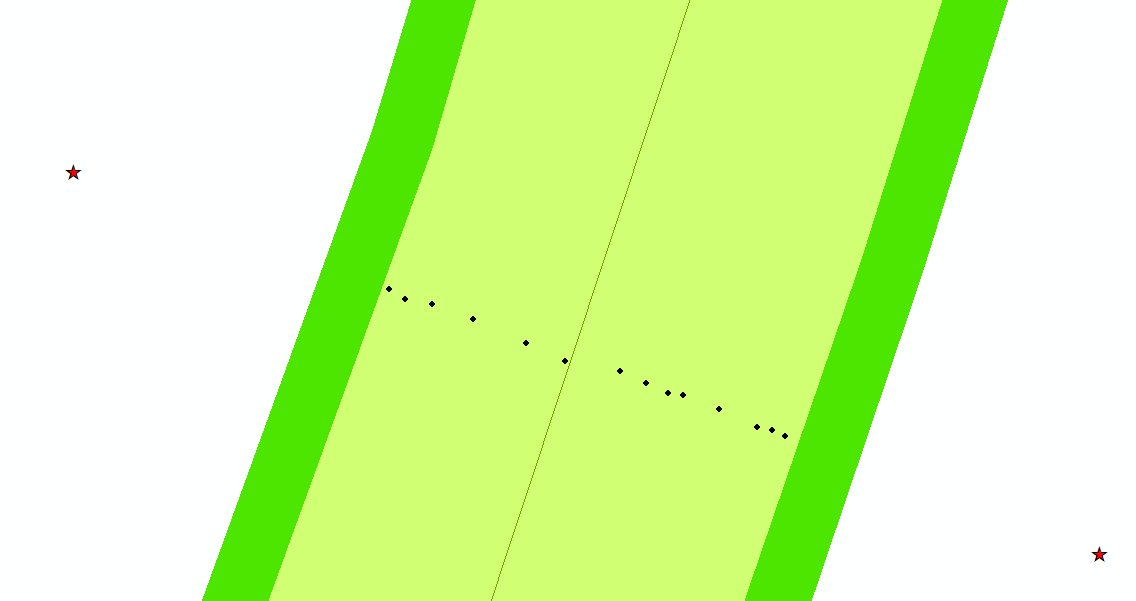 </div>

_Figuur: Meetpunten nat profiel (zwarten punten) & twee uiterste ge-extrapoleerde punten (rode sterren)_

In [6]:
class paths_function:
    shp_profielen_nat = paths.shp_profielen_nat # Input
    shp_points        = paths.shp_points # Output
    
functies_droog_profiel.fun_extrapolate(paths_function)

100%|████████████████████████████████████████████████████████████████████████████| 11575/11575 [03:28<00:00, 55.46it/s]


2. Trek een lijn door deze twee punten getrokken. Dit resulteert in een lange lijn door het orignele profiel.

In [7]:
class paths_function:
    shp_points        = paths.shp_points # Input
    shp_lines         = paths.shp_lines # Output
    
functies_droog_profiel.points_2_line(paths_function)

100%|████████████████████████████████████████████████████████████████████████████| 11575/11575 [02:06<00:00, 91.17it/s]


3. Knip de lijn met het insteekvlak

In [8]:
class paths_function:
    shp_lines         = paths.shp_lines # Input
    shp_insteek       = paths.shp_insteek # Input
    shp_HO            = paths.shp_HO # Input
    shp_lines_insteek = paths.shp_lines_insteek # Output
    
functies_droog_profiel.clip_line_by_polygon(paths_function)

4. Sla de uiteinden van de geknipte lijn op als punt-shapefile

In [9]:
import functies_droog_profiel
class paths_function:
    shp_lines_insteek   = paths.shp_lines_insteek # Input
    shp_points_insteek  = paths.shp_points_insteek # Output
    
functies_droog_profiel.lines_2_points(paths_function)

100%|██████████████████████████████████████████████████████████████████████████| 11572/11572 [00:04<00:00, 2456.48it/s]


#### AHN data uitlezen
Bij de insteekpunten (A24 & A28) worden nu AHN data uitgelezen.

Hierbij is de volgende filter toegepast:
- Is er geen AHN data beschikbaar op het insteekpunt? Neem dan het gemiddelde van een 0.5mx0.5m box rondom dat punt.
- Zijn de hoogte verschillen binnen deze box hoger dan 0.05m? Beschouw deze punt alsnog als "no data".

In [10]:
class paths_function:
    shp_points_insteek     = paths.shp_points_insteek # Input
    tif_AHN                = paths.tif_AHN # Input
    shp_points_insteek_AHN = paths.shp_points_insteek_AHN # Output
    
functies_droog_profiel.extract_data_along_points(paths_function)

#### Voeg de bestanden (droog & nat profiel) samen
Hierbij zijn profielen met de volgende criteria verwijderd:
- Profiel bevindt zich niet in het insteekvlak 
- Profiel bevindt zich gedeeltelijk in het insteekvlak (hierdoor zijn de punten A24/A28 niet aan de uiteinden van het profiel)

In [11]:
class paths_function:
    shp_profielen_nat       = paths.shp_profielen_nat # Input
    shp_points_insteek_AHN  = paths.shp_points_insteek_AHN # Input
    shp_points_incl_AHN     = paths.shp_points_incl_AHN # Output
    txt_dropped             = paths.txt_dropped # Output
    
functies_droog_profiel.merge_shapefiles(paths_function)

20  of  11575  profiles are dropped because it is not located in the insteekvlak. Check  D:\Users\Petra\DroogProfiel\Output\error.txt  for the ID codes.
2258  of  11555  profiles are dropped because the wet profile is shifted such that A24/A28 are not at the edges anymore. Check  D:\Users\Petra\DroogProfiel\Output\error.txt  for the ID codes.


100%|██████████████████████████████████████████████████████████████████████████████| 9297/9297 [11:04<00:00, 14.00it/s]


#### Extra punten toevoegen in het droge profiel
In sommige gevallen is de afstand tussen waterlijn en insteek groot. Bovendien zijn er onzekerheden rondom de locatie van de insteek. Daarom worden in de volgende functie punten toegevoegd in het droge gedeelte van het profiel zodat de afstand tussen punten niet groter is dan ongeveer 2.5 m.

In [12]:
class paths_function:
    shp_points_incl_AHN     = paths.shp_points_incl_AHN # Input
    tif_AHN                 = paths.tif_AHN # Input
    shp_points_AHN_all      = paths.shp_points_AHN_all # Output
    
functies_droog_profiel.extra_droge_punten(paths_function)

100%|████████████████████████████████████████████████████████████████████████████| 9297/9297 [6:13:56<00:00,  2.41s/it]


#### Filter profielen van lage kwaliteit
Op basis van een aantal criteria worden profilen van lage kwaliteit weggefilterd.
- AHN data beschikbaarheid: Profielen worden verwijderd als er links/rechts geen AHN data beschikbaar is.
- Maaiveld hoogte: Profielen worden verwijderd als de bodemhoogte bij de insteek (A24/A28) lager ligt dan aan de waterlijn (A22L/A22R)

In [13]:
class paths_function:
    shp_points_AHN_all      = paths.shp_points_AHN_all # Input
    shp_points_AHN_sel      = paths.shp_points_AHN_sel # Output
    txt_dropped             = paths.txt_dropped # Output    
functies_droog_profiel_filters.fun_filter(paths_function)

100%|██████████████████████████████████████████████████████████████████████████████| 9297/9297 [15:49<00:00,  9.80it/s]


385  of  9297  profiles are dropped because of missing AHN data at A24 or A28. Check  D:\Users\Petra\DroogProfiel\Output\error.txt  for the ID codes.
280  of  8912  profiles are dropped because of AHN data at A24/A28 is lower than at A22L/A22R. Check  D:\Users\Petra\DroogProfiel\Output\error.txt  for the ID codes.
81  of  8632  profiles are dropped because the minimum height is below -10 m NAP. Check  D:\Users\Petra\DroogProfiel\Output\error.txt  for the ID codes.


#### Controle per hydro object

In [14]:
class paths_function:
    shp_points_AHN_sel  = paths.shp_points_AHN_sel # Input
    shp_HO              = paths.shp_HO # Input
    txt_dropped         = paths.txt_dropped # Output
    
functies_droog_profiel_filters.final_check(paths_function)

68630  of  72256  hydro objects have no profile.
4805  of  8431  primary hydro objects have no profile. Check  D:\Users\Petra\DroogProfiel\Output\error.txt  for the ID codes.
3544  primary hydro objects are shorter than 100 m.


#### Verwijder tijdelijke bestanden

In [15]:
def fun_remove(path):
    folder = os.path.dirname(path)
    file   = os.path.basename(path).replace('shp','')
    fnames = [f for f in os.listdir(folder) if file in f]
    for f in fnames: os.remove(os.path.join(folder, f))
        
if False:
    fun_remove(paths.shp_points)
    fun_remove(paths.shp_lines)
    fun_remove(paths.shp_lines_insteek)
    fun_remove(paths.shp_points_insteek)
    fun_remove(paths.shp_points_insteek_AHN)
    fun_remove(paths.shp_points_incl_AHN)

In [16]:
tend = datetime.now()
dt   = (tend - tstart)/3600
print('Code running time: ', dt, ' hours')

Code running time:  0:00:08.050172  hours
